In [1]:
import pandas as pd

import requests

from time import sleep 

import tqdm
import re 

from typing import Dict, List 

# Downloading real estate ads from Sreality

* https://www.sreality.cz/api/cs/v2/estates?category_main_cb={cat_main}&category_type_cb={subtype}&no_auction=1&per_page=60

* base API link: https://www.sreality.cz/api/cs/v2/estates?
    * all real estate (RE) ads together (~90k)

```json
{
    'result_size': 89173,
    'embedded':[],
    'filter': ..., 
    '_links':{},
    'locality': "okres Praha 6",

    ...
    }

```

* ~ 90k is quite a lot for demonstration purposes -> restrict to flats only 
    * use **query argument** `category_main_cb`
        * some options: `{1: 'flat',2: 'house',3: 'land'}`
        * https://www.sreality.cz/api/cs/v2/estates?category_main_cb=1
            *  ```json
                {
                'result_size': 32472,
                'embedded':[],
                ...
                }
                ```

    * ! both sell and rent ads present - > restrict to sell only (for now)
        * use another **query argument** `category_type_cb`
            * `{1: 'sell', 2: 'rent'}`
            * https://www.sreality.cz/api/cs/v2/estates?category_main_cb=1&category_type_cb=1
    * still > 23k ads -> restrict to Prague only
        * use another query argument - `locality_region_id`
        * Prague : `locality_region_id=10`
        * \> 6k , we can work with this

In [2]:
cat_main = 1 # flat
cat_type = 1 # sell, not rent 
locality_region_id = 10# 

url = f'https://www.sreality.cz/api/cs/v2/estates?category_main_cb={cat_main}&category_type_cb={cat_type}&locality_region_id={locality_region_id}&per_page=60'
url

'https://www.sreality.cz/api/cs/v2/estates?category_main_cb=1&category_type_cb=1&locality_region_id=10&per_page=60'

In [3]:
r = requests.get(url)

In [4]:
r_json = r.json()

In [5]:
r_json['result_size']

6367

In [6]:
r_json.keys()

dict_keys(['meta_description', 'result_size', '_embedded', 'filterLabels', 'title', 'filter', '_links', 'locality', 'locality_dativ', 'logged_in', 'per_page', 'category_instrumental', 'page', 'filterLabels2'])

In [7]:
r.json()['_embedded'].keys()

dict_keys(['estates', 'is_saved', 'not_precise_location_count'])

In [8]:
r_json['_embedded']['estates']

[{'labelsReleased': [[], []],
  'has_panorama': 0,
  'labels': [],
  'is_auction': False,
  'labelsAll': [['personal',
    'panel',
    'cellar',
    'elevator',
    'parking_lots',
    'partly_furnished'],
   ['small_shop',
    'candy_shop',
    'tavern',
    'vet',
    'playground',
    'theater',
    'movies',
    'drugstore',
    'bus_public_transport',
    'restaurant',
    'metro',
    'school',
    'tram',
    'train',
    'medic',
    'sports',
    'shop',
    'kindergarten',
    'post_office',
    'atm']],
  'seo': {'category_main_cb': 1,
   'category_sub_cb': 4,
   'category_type_cb': 1,
   'locality': 'praha-krc-hurbanova'},
  'exclusively_at_rk': 0,
  'category': 1,
  'has_floor_plan': 0,
  '_embedded': {'favourite': {'is_favourite': False,
    '_links': {'self': {'profile': '/favourite/doc',
      'href': '/cs/v2/favourite/3989894988',
      'title': 'Oblibene inzeraty'}}},
   'note': {'note': '',
    '_links': {'self': {'profile': '/note/doc',
      'href': '/cs/v2/note/3

In [9]:
estates_raw= r_json['_embedded']['estates']

In [10]:
estates_raw.__len__()

61

* ! only 60 ads (out of 6k we want)
* we will need to iterate to collect the ads
* before we get to that, lets look at the example estate

In [11]:
estate_ex = estates_raw[0]

* what attributes do we want to collect ? 

In [12]:
estate_ex.keys()

dict_keys(['labelsReleased', 'has_panorama', 'labels', 'is_auction', 'labelsAll', 'seo', 'exclusively_at_rk', 'category', 'has_floor_plan', '_embedded', 'paid_logo', 'locality', 'has_video', 'advert_images_count', 'new', 'auctionPrice', 'type', 'hash_id', 'attractive_offer', 'price', 'price_czk', '_links', 'rus', 'name', 'region_tip', 'gps', 'has_matterport_url'])

In [14]:
estate_ex;

* these look reasonable: 
    * ['locality', 'price', 'price_czk', 'name', 'gps', 'type', 'hash_id', 'labelsAll', 'area' (looks like only in the name)]

## Iterating top (all-estates) level

* query argument `page`
* let's try just first 3 pages first 
* good ideas:
    * persist downloaded raw data! (no need to hit server again if we want to continue later)
        * storage is cheap! 
    * sleep between requests in order not to overwhelm the server


* QUESTION: we could be extracting as we are iterating during the download or separately, can you think about pros and cons of each approach?


In [15]:
raw_collector = {}
pages = range(1,4)
for i in pages:
    base_url = 'https://www.sreality.cz/api/cs/v2/estates?category_main_cb=1&category_type_cb=1&locality_region_id=10&per_page60&page={}'.format(i)

    r = requests.get(base_url)
    raw_collector[i] = r.json()
    sleep(1)

* now we will iterate over the dowloaded raw data 
* each iteration is one page which consists of multiple estates
* => we will need to iterate once more but over the individual estates

* for now we are just tinkering and figuring out how it works, good design will come later (but you can definitely think about it and make notes! )

* we also know from above what we are interested in: 
    * ['locality', 'price', 'price_czk', 'name', 'gps', 'type', 'hash_id', 'labelsAll', 'area' (looks like only in the name)]
    * 'labelsAll' contains both info about the estate (e.g. furnished) and list of nearby things (e.g. tavern)

* we have individual estates, but still raw and in jsons
* need to get attributes to certain type (and single value to fit DataFrame nicely)
* complications in following attributes:
    * area (only in name) -> derive 
    * gps (latitude and longtitude together) -> split
    * labelsAll (different lengths and contents of the list for different estates) -> make categorical variable ?!


In [16]:
def get_gps_lat_lon(estate_raw: Dict):
    gps_ = estate_raw['gps']
    return gps_['lat'], gps_['lon']

def get_flat_type_from_name(name: str):
    # Name is always represented by string "Prodej bytu [type of flat] [Area] m^2"
    return name.split()[2]

def get_area_from_name_naive(name: str):
    return int(name.split()[3])

# more robust implementation using regex - https://docs.python.org/3/library/re.html
def get_area_from_name(name: str):
    """(\d*) matches any decimal digits (repeated after each other"""
    name_ = name.split()
    return int(''.join(re.findall('(\d*)', ''.join(name_[3:]))))


In [17]:
?re.findall

Signature: re.findall(pattern, string, flags=0)
Docstring:
Return a list of all non-overlapping matches in the string.

If one or more capturing groups are present in the pattern, return
a list of groups; this will be a list of tuples if the pattern
has more than one group.

Empty matches are included in the result.
File:      /usr/lib/python3.8/re.py
Type:      function


In [18]:
# slow helper functions (use itertools.chains for speedup)
def flatten_list(l:List):
    return [item for sublist in l for item in sublist]

def get_distinct_nearby_objects(estates_individual_raw: Dict):
    lists_of_nearby_objects = [e['labelsAll'][1] for e in estates_individual_raw.values()]
    return list(set(flatten_list(lists_of_nearby_objects)))

def get_distinct_estate_attributes(estates_individual_raw: Dict):
    lists_of_estates_attributes = [e['labelsAll'][0] for e in estates_individual_raw.values()]
    return list(set(flatten_list(lists_of_estates_attributes)))

In [19]:
raw_attributes_to_collect = ['locality', 'price', 'name', 'gps','hash_id','labelsAll','exclusively_at_rk']

estates_individual_raw = {}
estates_individual = {}

for page, r in raw_collector.items():
    for estate in r['_embedded']['estates']: 

        estate_raw = {k:v for k,v in estate.items() if k in raw_attributes_to_collect}

        estate_relevant = pd.Series()

        estate_relevant['price'] = int(estate['price'])
        estate_relevant['area'] = get_area_from_name(estate['name'])

        lat, lon = get_gps_lat_lon(estate)
        estate_relevant.loc['gps_lat'] = lat
        estate_relevant.loc['gps_lon'] = lon
        estate_relevant['locality'] = estate['locality']

        estate_relevant['flat_type'] = get_flat_type_from_name(estate['name'])


        estates_individual_raw[estate['hash_id']] = estate_raw
        estates_individual[estate['hash_id']] = estate_relevant

<ipython-input-19-508413fcdbb0>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  estate_relevant = pd.Series()


In [20]:
get_distinct_nearby_objects(estates_individual_raw);
get_distinct_estate_attributes(estates_individual_raw);

In [21]:
df = pd.concat(estates_individual).unstack()

In [22]:
df.head()

,price,area,gps_lat,gps_lon,locality,flat_type
1038489420,16922000.0,113.0,50.073313,14.457296,Praha 3 - Žižkov,4+kk
3555198796,4249000.0,49.0,50.022703,14.530749,Praha 4 - Chodov,2+kk
1839380300,19943000.0,105.0,50.048197,14.378239,Praha 5,3+kk
3441223244,7442000.0,91.0,50.033476,14.34451,Praha 5 - Stodůlky,3+kk
895043148,5166000.0,32.0,50.018465,14.604948,Praha 10 - Uhříněves,1+kk


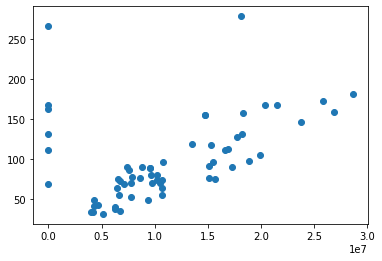

In [23]:
import matplotlib.pyplot as plt 
plt.scatter(df['price'],df['area'])

## Persist to sqlite

In [33]:
import sqlite3

In [34]:
con = sqlite3.connect('redata.sqlite')

In [36]:
df.head()

,price,area,gps_lat,gps_lon,locality,flat_type
1038489420,16922000.0,113.0,50.073313,14.457296,Praha 3 - Žižkov,4+kk
3555198796,4249000.0,49.0,50.022703,14.530749,Praha 4 - Chodov,2+kk
1839380300,19943000.0,105.0,50.048197,14.378239,Praha 5,3+kk
3441223244,7442000.0,91.0,50.033476,14.34451,Praha 5 - Stodůlky,3+kk
895043148,5166000.0,32.0,50.018465,14.604948,Praha 10 - Uhříněves,1+kk


In [37]:
df.to_sql(name = 'df', con= con, index = False)

In [38]:
del df

In [39]:
df

NameError: name 'df' is not defined

In [41]:
# load again from the storage
df = pd.read_sql('SELECT * FROM df', con = con)

In [42]:
df.dtypes

price        float64
area         float64
gps_lat      float64
gps_lon      float64
locality      object
flat_type     object
dtype: object

## Before packing and run script

* handling errors
* need to identify we've covered all (top-level pages)
    * we could estimate the number of using the `result_size` attribute
    * or we could check if there is something different when we run out of pages to collect
        * e.g. 'message': 'Not found'

* see 04_Seminar-APIs_DBs for more details!